![banner](fpl-banner.jpeg)

# Champion's Code: Mastering FPL Predictions with Machine Learning

## 1. Introduction

In the ever-evolving landscape of sports analytics and data-driven decision-making, the world of fantasy sports stands at the intersection of passion and data science. Fantasy Premier League (FPL) enthusiasts worldwide engage in a virtual football manager experience, meticulously selecting players to form their dream teams within budgetary constraints. The strategic selection of players, based on their real-life performance and upcoming fixtures, is not just a game; it's an intricate data science challenge.

This document chronicles the journey of developing an innovative solution: a Fantasy Premier League predicter powered by simple machine learning techniques. The goal of this project is to leverage the wealth of FPL datasets to predict total FPL points for upcoming fixtures, based on opponent and player performance metrics. 

![banner](fpl-screenshot.jpeg)

## 2. Scope & Project Objectives:

### Data Preparation:

Create comprehensive datasets containing active players in the current premier league campaign, as well as individual and team game-week performance metrics. The datasets will be saved as a csv, with the option to refresh to live data.


### EDA and Feature Engineering:

Identify and select relevant player performance features that can influence FPL points.
Analyze the importance of each feature in predicting player points using exploratory data analysis and correlation/feature importance techniques. Create new features that can improve the model based on analysis.

### Model Selection and Training:

Experiment with different regression models such as Linear Regression, Random Forest, Gradient Boosting and XGBoosting to identify the most suitable model.
Split the dataset into training and testing sets for model evaluation.
Train the selected model using player performance data.

### Model Evaluation and Hyper Parameters:

Evaluate the model's performance using appropriate metrics such as Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).
Validate the model using cross-validation techniques to ensure robustness and reliability. Tune hyper-parameters using GridSearchCV to find optimal parameters

## 3. Data Description
### Data Load, Transform and Clean

In this study, the primary source of data was the official Fantasy Premier League API provided by the Premier League. The API is free to use and accesible to anyone, under the condition that is not used to make profits. The API endpoints used for data retrieval were as follows:

**Bootstrap-Static Endpoint:** The bootstrap-static endpoint was accessed to acquire comprehensive information about the players participating in the current FPL season from start to date. This endpoint provided essential player details such as IDs, names, positions, and relevant team affiliations. The data obtained from this endpoint formed the foundational dataset for player analysis.

Endpoint URL: https://fantasy.premierleague.com/api/bootstrap-static/

**Individual Player Data Endpoint:** To delve into the granular aspects of player performance, the element-summary endpoint was employed. By appending specific player IDs to the endpoint URL, in-depth statistics for individual players were retrieved. These statistics encompassed a wide array of metrics for the current season, including goals scored, assists, clean sheets, and injury status, among others.

Endpoint URL Template: https://fantasy.premierleague.com/api/element-summary/{player-id}/

The data obtained from these API endpoints was in the form of structured JSON (JavaScript Object Notation) responses. These responses were processed and transformed into tabular data, which was further utilized for exploratory data analysis, feature engineering, and model development.



In [1]:
# Initial imports and function definitions. 
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create function to get individual gameweek history for all players
def get_gameweek_history(player_id):
    '''get all gameweek info for a given player_id'''
    
    # send GET request to
    # https://fantasy.premierleague.com/api/element-summary/{PID}/
    r = requests.get(
            base_url + 'element-summary/' + str(player_id) + '/'
    ).json()
    
    # extract 'history' data from response into dataframe
    df = pd.json_normalize(r['history'])
    
    return df

In [3]:
# It is recommended to only refresh during the 2023/2024 Premier League season.
REFRESH = False  # Change this to True if you want to refresh the data

# Base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# Check if REFRESH is True, then refresh the data
if REFRESH:
    # Get data from bootstrap-static endpoint
    r = requests.get(base_url + 'bootstrap-static/').json()

    # Create players dataframe
    players_df = pd.json_normalize(r['elements'])

    # Create teams dataframe
    teams_df = pd.json_normalize(r['teams'])

    # Get position information from 'element_types' field
    positions_df = pd.json_normalize(r['element_types'])

    # Select columns of interest from players df
    players_df = players_df[
    ['id', 'first_name', 'second_name', 'web_name', 'team',
     'element_type']
    ]

    # Join team name
    players_df = players_df.merge(
        teams_df[['id', 'name']],
        left_on='team',
        right_on='id',
        suffixes=['_player', None]
    ).drop(['id'], axis=1).rename(columns={
        'team': 'id_team','name':'team'})

    # Join player positions
    players_df = players_df.merge(
        positions_df[['id', 'singular_name_short']],
        left_on='element_type',
        right_on='id'
    ).drop(['id'], axis=1).rename(columns={
        'singular_name_short': 'position','element_type':'id_position'})

    # Create player_points to store each player's individual gw stats
    player_points = players_df['id_player'].apply(get_gameweek_history)

    # Combine results into single dataframe
    player_points = pd.concat(df for df in player_points)

    # Join players_df for web_name, team and position
    player_points = players_df[['id_player','web_name','id_team','team','id_position','position']].merge(
        player_points,
        left_on='id_player',
        right_on='element'
    ).rename(columns={
        'web_name': 'player', 'opponent_team':'id_opponent'}
    ).drop('element', axis=1)

    # Join team name for opponent
    player_points = player_points.merge(
        teams_df[['id', 'name']],
        left_on='id_opponent',
        right_on='id',
        suffixes=['_x', '_y']
    ).rename(columns={'name':'opponent'}
    ).drop('id', axis=1)

    # Save as player_points.csv 
    player_points.to_csv('player_points.csv')

else:
    # If REFRESH is False, load data from existing CSV file
    player_points = pd.read_csv('player_points.csv')
    
# Check for nulls (optional)
player_points.isnull().sum()

# Data Clean
# Convert kickoff_time to datetime
player_points['kickoff_time']=pd.to_datetime(player_points['kickoff_time'])

It is important to note that all data gathered from the FPL API was anonymized and utilized solely for academic and research purposes. The dataset used in this study represents a snapshot of player and fixture information available at the time of data collection.

Below is example of our player and fixture snapshot, detailing Erling Halaand's game-week performance metrics for the 2023/2024 season:

In [4]:
features=['round','player','team','position','value','total_points','opponent','was_home','kickoff_time','team_h_score','team_a_score','minutes','goals_scored','assists','influence','creativity','threat','ict_index']
erling = player_points[player_points['player']=='Haaland']
erling[features].sort_values('round')

,round,player,team,position,value,total_points,opponent,was_home,kickoff_time,team_h_score,team_a_score,minutes,goals_scored,assists,influence,creativity,threat,ict_index
3859,1,Haaland,Man City,FWD,140,13,Burnley,False,2023-08-11 19:00:00+00:00,0,3,79,2,0,67.6,23.7,48.0,13.9
3523,2,Haaland,Man City,FWD,140,2,Newcastle,True,2023-08-19 19:00:00+00:00,1,0,90,0,0,3.2,11.8,48.0,6.3
3175,3,Haaland,Man City,FWD,140,4,Sheffield Utd,False,2023-08-27 13:00:00+00:00,1,2,90,1,0,34.2,12.9,97.0,14.4
765,4,Haaland,Man City,FWD,140,20,Fulham,True,2023-09-02 14:00:00+00:00,5,1,90,3,1,119.4,23.4,55.0,19.8
5297,5,Haaland,Man City,FWD,141,6,West Ham,False,2023-09-16 14:00:00+00:00,1,3,90,1,0,41.2,14.5,118.0,17.4
37,6,Haaland,Man City,FWD,141,6,Nott'm Forest,True,2023-09-23 14:00:00+00:00,2,0,90,1,0,32.4,3.3,23.0,5.9
4955,7,Haaland,Man City,FWD,141,2,Wolves,False,2023-09-30 14:00:00+00:00,2,1,90,0,0,6.0,12.6,27.0,4.6
6383,8,Haaland,Man City,FWD,141,2,Arsenal,False,2023-10-08 15:30:00+00:00,1,0,90,0,0,7.8,21.8,8.0,3.8
4607,9,Haaland,Man City,FWD,140,8,Brighton,True,2023-10-21 14:00:00+00:00,2,1,90,1,0,38.6,0.9,26.0,6.6
1102,10,Haaland,Man City,FWD,140,16,Man Utd,False,2023-10-29 15:30:00+00:00,0,3,90,2,1,89.2,12.8,106.0,20.8


## 4. Exploratory Data Analysis (EDA)

In this phase of the study, a comprehensive Exploratory Data Analysis (EDA) was conducted on the acquired FPL datasets. EDA serves as the cornerstone of our research, enabling us to unravel intricate patterns, dependencies, and outliers within the data. The primary objectives of our EDA were twofold: firstly, to gain a profound understanding of the underlying characteristics of the FPL datasets, and secondly, to identify key features that exhibit significant correlations with players' game week points across different metrics such as player positions, club and individual player preformances.

### Minutes Played and Price KDE Plots

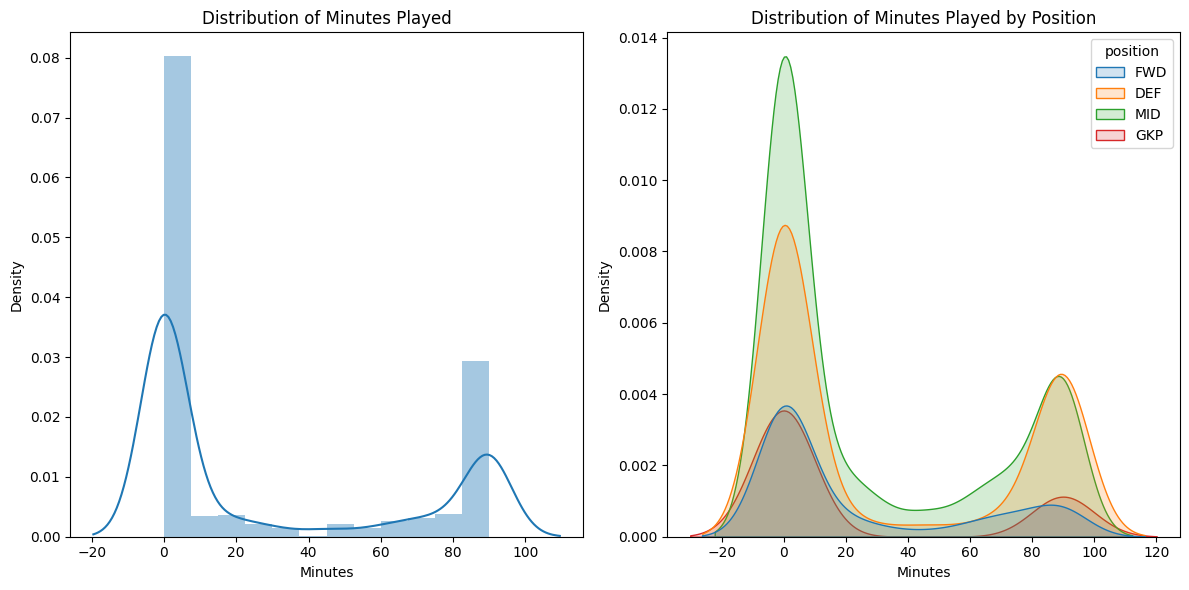

In [5]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Distribution of Minutes Played
sns.distplot(player_points.minutes, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Minutes Played")
axes[0].set_xlabel("Minutes")

# Plot 2: Distribution of Minutes Played by Position
sns.kdeplot(data=player_points, x='minutes', hue='position', fill=True, alpha=0.2, ax=axes[1])
axes[1].set_title("Distribution of Minutes Played by Position")
axes[1].set_xlabel("Minutes")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


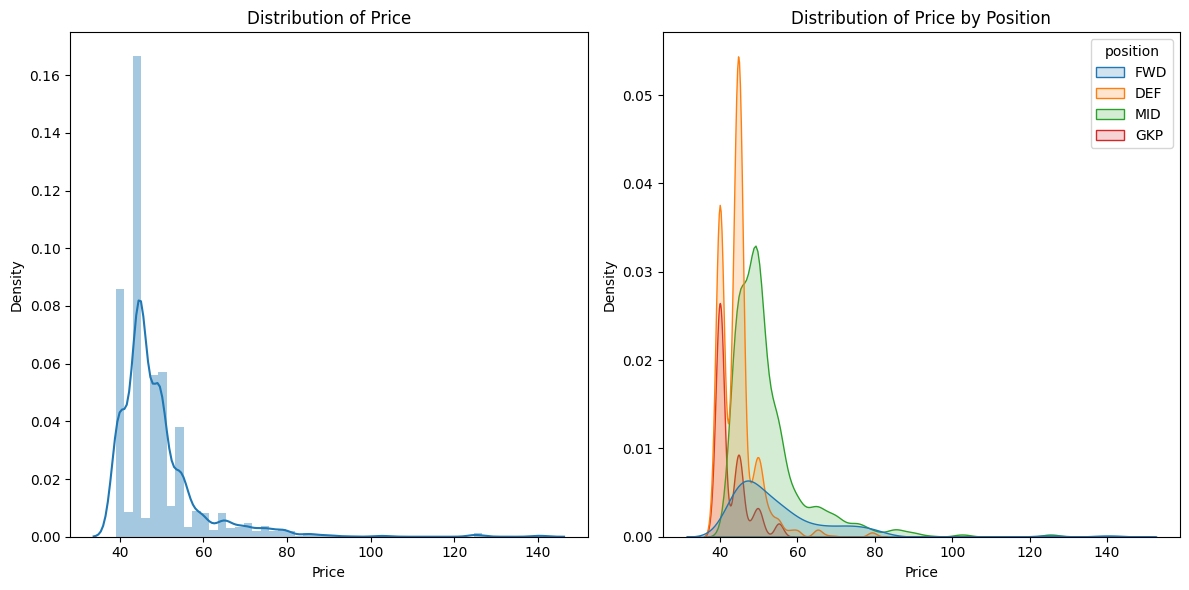

In [13]:
import numpy as np

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Distribution of Price
sns.distplot(player_points['value'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Price")
axes[0].set_xlabel("Price")

# Plot 2: Distribution of Minutes Played by Position
sns.kdeplot(data=player_points, x='value', hue='position', fill=True, alpha=0.2, ax=axes[1])
axes[1].set_title("Distribution of Price by Position")
axes[1].set_xlabel("Price")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


The kernal-desnsity plots (KDE) above plots the distribution of minutes played per player, with an additional split by player postion on the right. Both plots convey that a large portion of the population contains data for inactive players, additionally the right-hand plot conveys that the distrubution of midfielders and defenders are similar, and are twice as large as the distribution of goalkeepers and forwards which are also similar. Furthermore, goalkeepers are the only playing position that holds no density between 0 and 90 minutes, meaning goalkeepers are rarely subbed-off and replaced during a match. 

Although the large volumes of inactive players are relevant for teaching our model (as inactive players receive 0 points), they are not needed for the rest of our EDA which investigates which features impact player points for _active_ players, and will therefore be filtered out.

### Total Points vs Price Plots

The graphic below inspected statistics between playing position and total points gained vs individual player price, and has been filtered to include only active players which have contributed minutes this season.

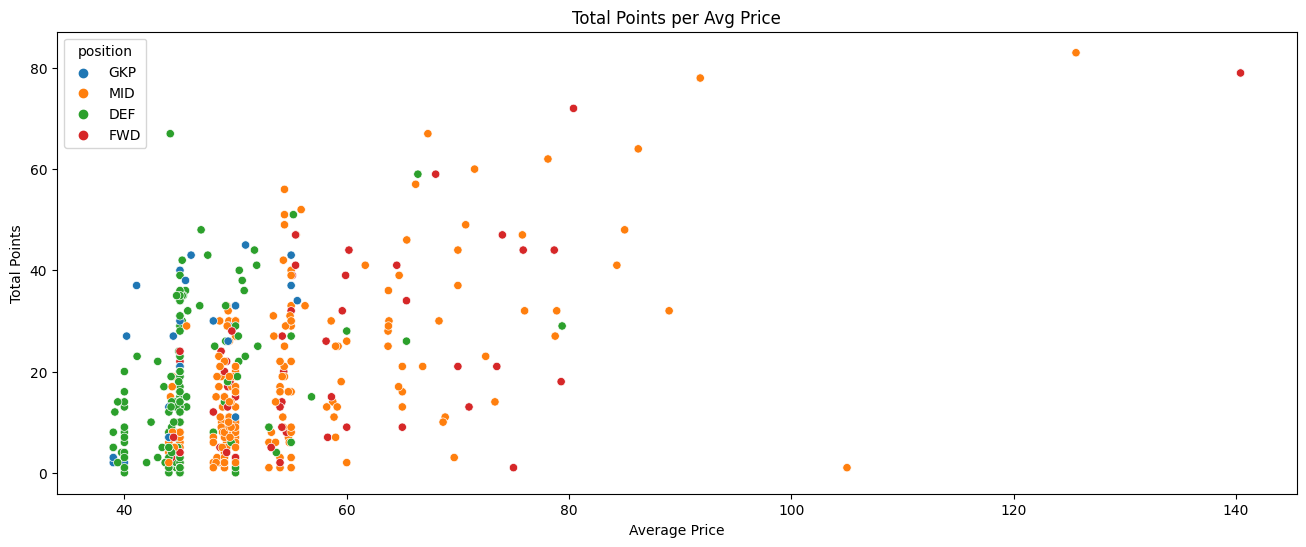

In [14]:
# Filter players who are active this season
df = player_points[player_points['minutes'] > 0].groupby(['player','position']).agg({'value':'mean','total_points':'sum'}).reset_index()

# Set up the figure with two subplots
plt.figure(figsize=(16, 6))
sns.scatterplot(x='value',y='total_points',data=df,hue='position')
plt.xlabel('Average Price')
plt.ylabel('Total Points')
plt.title('Total Points per Avg Price')

# Display the plots
plt.show()


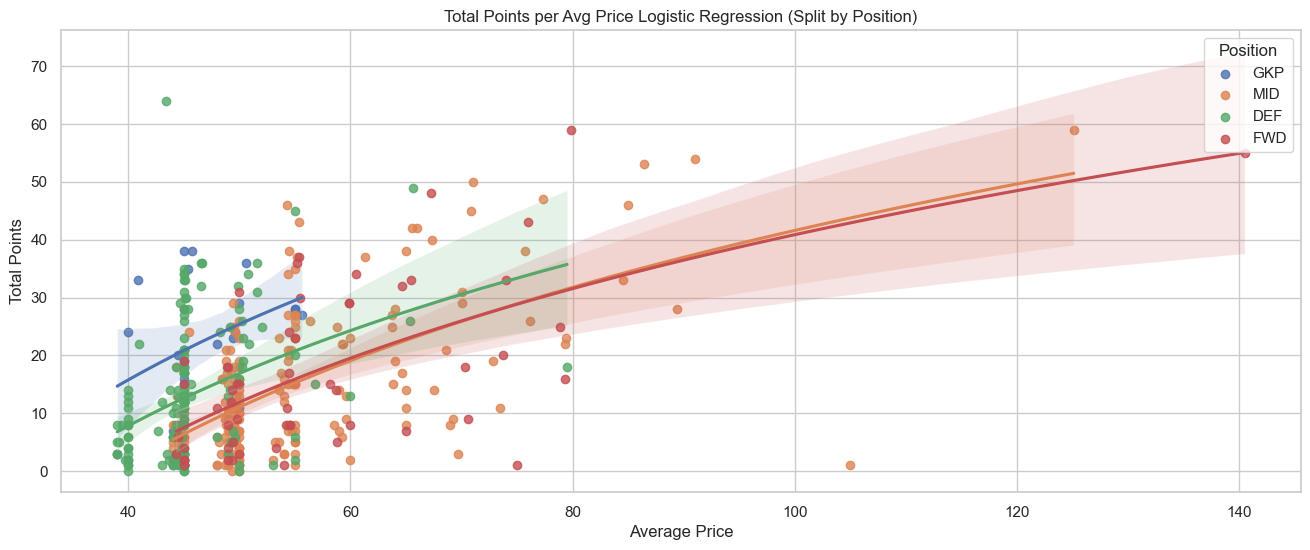

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter players who are active this season
df = player_points[player_points['minutes'] > 0].groupby(['player','position']).agg({'value':'mean','total_points':'sum'}).reset_index()

# Set up the figure with individual subplots for each position
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
positions = df['position'].unique()

# Iterate through each position and create a regression plot for each
for position in positions:
    position_df = df[df['position'] == position]
    sns.regplot(x='value', y='total_points', data=position_df, logx=True,  label=position)

plt.xlabel('Average Price')
plt.ylabel('Total Points')
plt.title('Total Points per Avg Price Logistic Regression (Split by Position)')
plt.legend(title='Position')
plt.show()


The plot hints at a logarithmic-like pattern, where the increase in total points may not be directly proportional to the rise in player price. This observation aligns with the idea that as player prices increase, the rate of increase in total points might slow down, resembling a logarithmic relationship expressed as y = log(x), with MID and FWD showing very similar curves 

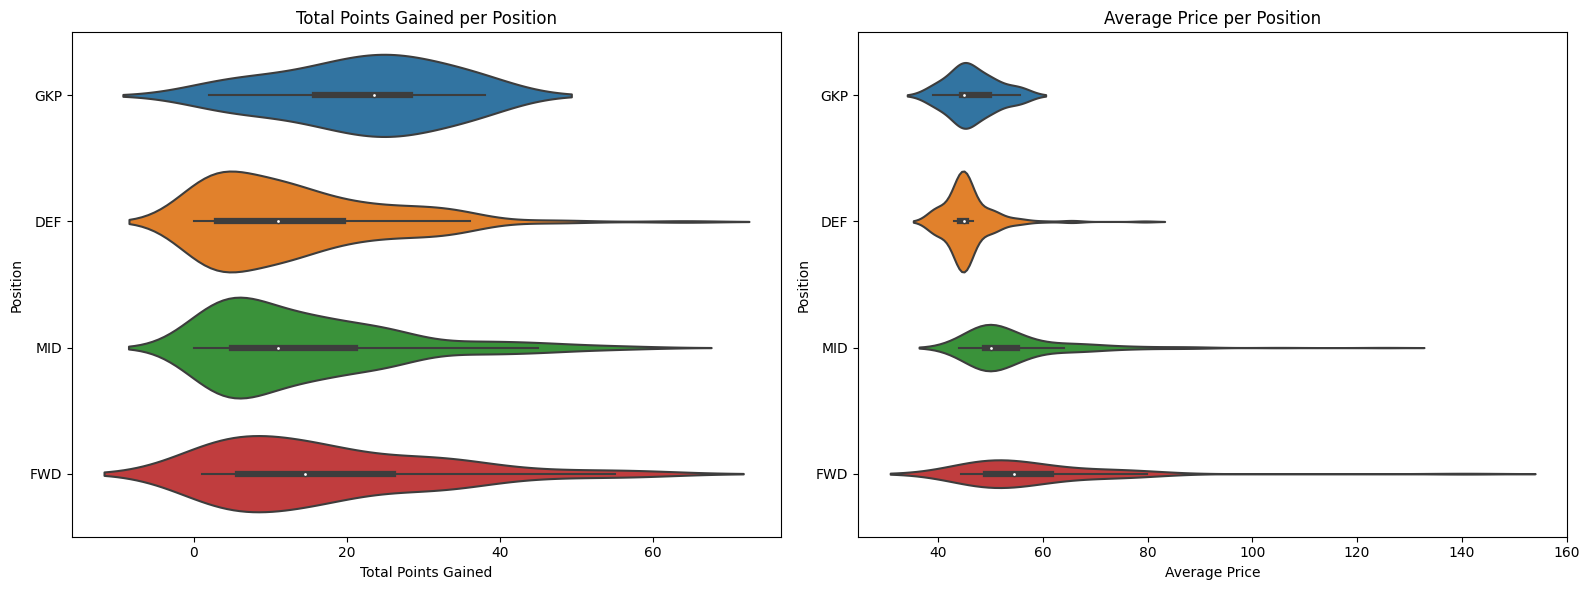

In [12]:
# Filter players who are active this season
df = player_points[player_points['minutes'] > 0].groupby(['player','position']).agg({'value':'mean','total_points':'sum'}).reset_index()

# Set up the figure with two subplots
plt.figure(figsize=(16, 6))

# Plot 1: Violin plot of average points gained per position
plt.subplot(1, 2, 1)
sns.violinplot(x='total_points', y='position', data=df, order=['GKP', 'DEF', 'MID', 'FWD'])
plt.xlabel('Total Points Gained')
plt.ylabel('Position')
plt.title('Total Points Gained per Position')

# Plot 2: Violin plot of price vs total points
plt.subplot(1, 2, 2)
sns.violinplot(x='value', y='position', data=df, order=['GKP', 'DEF', 'MID', 'FWD'])
plt.xlabel('Average Price')
plt.ylabel('Position')
plt.title('Average Price per Position')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()




As evident in the violin plots above, the relationship between player price and points exhibits higher volatility for midfielders and forwards in contrast to defenders and goalkeepers. This disparity underscores a heightened risk-to-reward ratio for attacking players, emphasizing the need for careful consideration when opting for high-risk, high-reward attacking options.

### t-SNE Plot

t-SNE (t-Distributed Stochastic Neighbor Embedding) works by modeling the similarity between data points in the high-dimensional space and the low-dimensional space. It then tries to minimize the difference between these similarities, effectively mapping the high-dimensional data to a lower-dimensional space while preserving the relationships between the data points.

By emploring t-SNE on the numerica gameweek performance metrics, `goals_scored`,`assists`,`own_goals`,`saves`,`minutes`,`threat`,`creativity`,`influence`,`ict_index`, we plot their relationship by t-SNE and notice a potential relational with playing position.

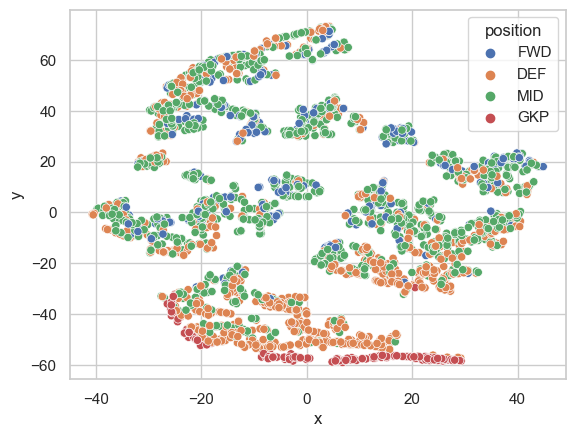

In [16]:
# Filter out inactive players
df = player_points[player_points['minutes']>0]

# Define numeric features used for clustering
features= ['goals_scored','assists','own_goals','saves','minutes','threat','creativity','influence','ict_index']
df_numeric = df[features]

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50, random_state=1)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(df_numeric)

df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

# Color the points by Gender
sns.scatterplot(x="x", y="y", hue='position', data=df)

# Show the plot
plt.show()

### Feature Correlation

Correlation matrices were employed, both global and position-specific, to quantify relationships between features and game week points (the target of this study). A focus was placed on features such as goals, assists, clean sheets, yellow and red cards, against player positions. Correlation analyses enabled us to discern which attributes held the strongest influence on player points, aiding in the construction of our predictive models.

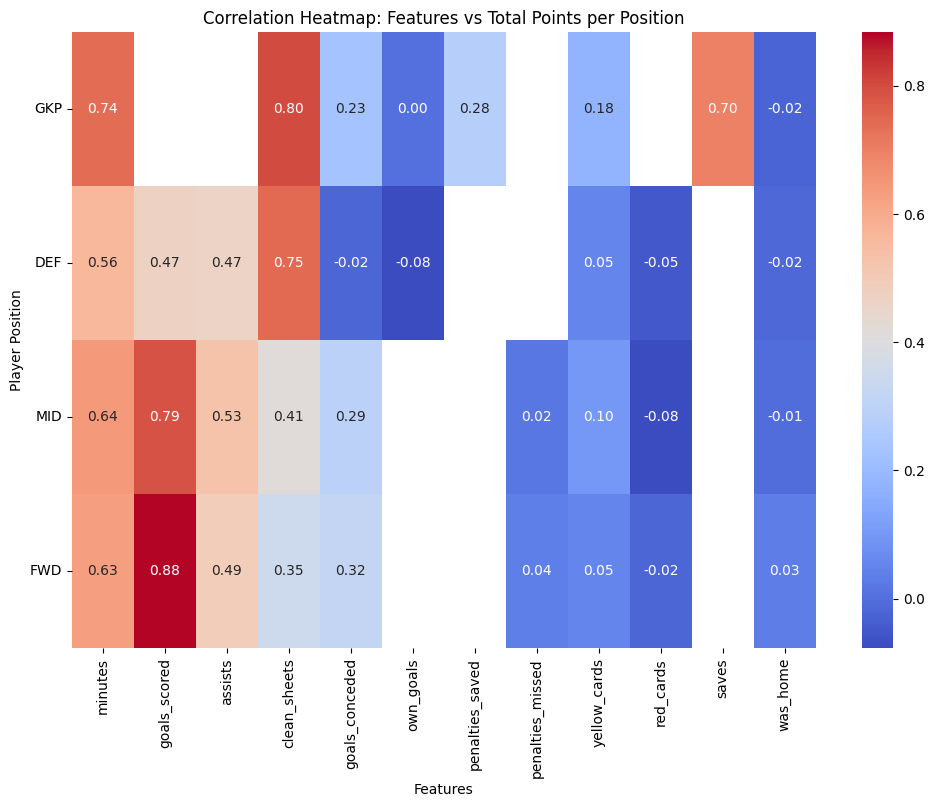

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features to be considered for correlation heatmap
features = ['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 
            'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 
            'red_cards', 'saves','was_home']

# Define the desired order for the y-axis (player positions)
order = ['GKP', 'DEF', 'MID', 'FWD']

# Calculate correlations for each player position
correlations = player_points.groupby('position')[features + ['total_points']].corr()

# Reorder the index of the correlations DataFrame based on the desired order
correlations = correlations.loc[order, :, :]

# Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations.loc[(slice(None), 'total_points'), features], annot=True, cmap='coolwarm', fmt=".2f",yticklabels=order)

# Rename the y-axis ticks to match position names
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], rotation=0)
plt.xlabel('Features')
plt.ylabel('Player Position')
plt.title('Correlation Heatmap: Features vs Total Points per Position')
plt.show()


Another correlation heatmap was employed below, this time a Spearman correlation between the FPL performance metrics `influence`, `creativity`, `threat`, `ict_index`, `bps` and `total_points`.

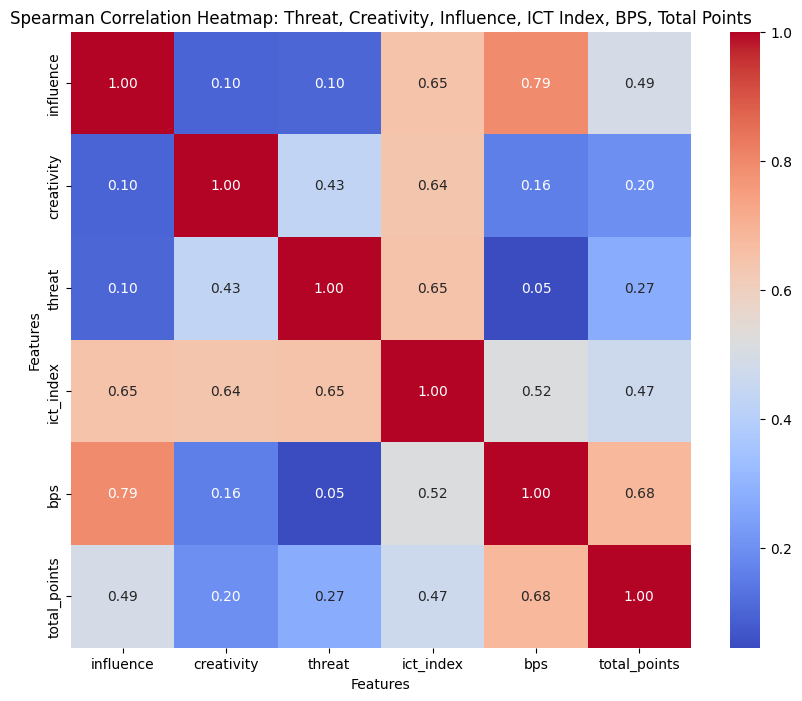

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter players who have played more than 30 mins per game
df = player_points[player_points['minutes'] > 30]

# Specify the features to be considered for correlation heatmap
features = ['influence', 'creativity', 'threat', 'ict_index','bps','total_points']

# Convert features into floats
df[features] = df[features].astype(float)

# Calculate Spearman correlations for the specified features
correlations = df[features].corr(method='spearman')

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=features, yticklabels=features)

plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Spearman Correlation Heatmap: Threat, Creativity, Influence, ICT Index, BPS, Total Points')
plt.show()


The correlation heatmap infers that all metrics have a linear relationship with total points, `threat` and `creativity` are weak relationships and `influence` and `ict_index` moderate. `bps` has a good linear relationship with total points, as well as a strong linear relationship with `influence`.

## 5. Feature Engineering

In the context of our project, while FPL performance metrics such as `bps` exhibit correlations with player points, it is available only after the match and cannot be utilized for predicting upcoming results. However, we can leverage this metric to calculate form ratings. This approach involves assessing each player's performance over their last 3 matches, creating a representation of their current form leading into the game, and is applied to `bps`, `minutes`, and `total_points` to create `bps_form`, `points_form` and `minutes_form`.

In [48]:
# Order by round
player_points = player_points.sort_values('round')

# Calculate rolling mean for previous 3 gameweeks
player_points['points_form'] = round(player_points.groupby('id_player')['total_points'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True),1)

# Lag the points_form values by one round
player_points['points_form'] = player_points.groupby('id_player')['points_form'].shift(fill_value=0)

# Calculate rolling mean for previous 3 gameweeks
player_points['minutes_form'] = round(player_points.groupby('id_player')['minutes'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True),1)

# Lag the points_form values by one round
player_points['minutes_form'] = player_points.groupby('id_player')['minutes_form'].shift(fill_value=0)

# Calculate rolling mean for previous 3 gameweeks
player_points['bps_form'] = round(player_points.groupby('id_player')['bps'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True),1)

# Lag the points_form values by one round
player_points['bps_form'] = player_points.groupby('id_player')['bps_form'].shift(fill_value=0)

We can also consider generating a new feature: the average minutes played by a player in the last 3 matches. This metric provides insights into a player's activity within the team and reflects the number of minutes they have actively participated in recent matches, as it's crucial to note that players on the bench receive 0 points.

A final Spearman correlation heatmap on all selected features is shown below.

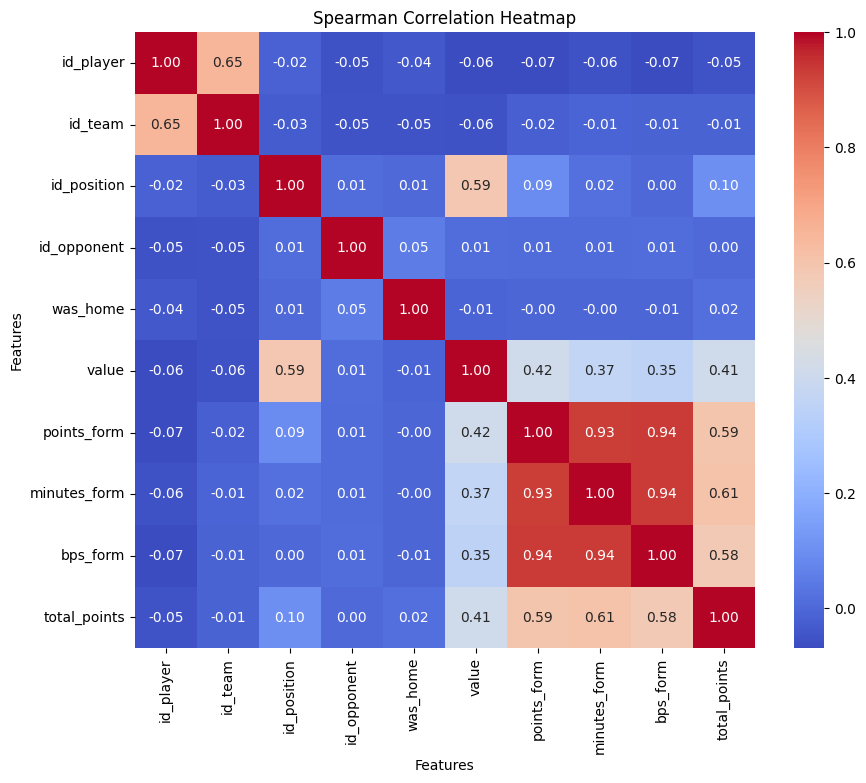

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the features to be considered for correlation heatmap
features=['id_player','id_team','id_position','id_opponent','was_home','value','points_form','minutes_form','bps_form','total_points']

# Calculate Spearman correlations for the specified features
correlations = player_points[features].corr(method='spearman')

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=features, yticklabels=features)

plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Spearman Correlation Heatmap')
plt.show()

The heatmap is heavily skewed towards the bottom right, implying that our new features `points_form` and `minutes_form` are strongly correlated with players total points. Its also worth mentioning that these features have a very strong linear relationship with each other, which doesn't come as a surprise as a player is required to participate to score points, and the more minutes played increases the probability that a player will score points.

## 6. Machine Learning Model Development
### 6.1 Model Selection:
Choosing the right machine learning algorithms is crucial for accurate predictions in regression tasks. In our project, where the goal is to forecast players' fantasy points, we are dealing with a regression problem. We will explore several algorithms to determine the one that best captures the intricate patterns within the FPL data. Our focus will be on well-known algorithms which are well-suited for regression tasks. These models are:

1. **Linear Regression:**
    Linear Regression assumes a linear relationship between the input features and the target   variable. The goal of linear regression is to find the best-fit line that minimizes the sum of the  squared differences between the predicted and actual values.

2. **Random Forest:**
    Random Forest is an ensemble learning method that operates by constructing multiple decision   trees during training and outputs the average prediction of the individual trees. It is         resilient to overfitting, making it a popular choice for regression tasks, especially when          dealing with complex datasets like FPL player statistics.

3. **Gradient Boosting:**
    Gradient Boosting is another ensemble technique that builds multiple decision trees sequentially, with each tree correcting the errors of its predecessor. It's highly effective for regression tasks, capable of capturing subtle patterns in the data. By combining the predictions of weak learners, Gradient Boosting often results in powerful and accurate models.

4. **XGBoost:**
    XGBoost is a specific implementation of gradient boosting that is highly efficient and scalable. It incorporates several enhancements, such as regularized learning objectives, parallelization, and handling missing values, making it faster and more accurate than traditional gradient boosting implementations.

### 6.2 Feature Scaling

Feature scaling is a technique used in machine learning to standardize the range of independent variables or features of a dataset. It is also known as data normalization. The goal of feature scaling is to bring all features to the same scale so that no single feature dominates the others.

There are two common methods for feature scaling:

1. **Standardization**: It transforms the data to have zero mean and unit variance. This method subtracts the mean value of each feature and then divides it by the standard deviation.

2. **Normalization**: It scales the data to a fixed range, usually between 0 and 1. This method subtracts the minimum value of each feature and then divides it by the range (maximum value minus minimum value).

This project will make use of a Standardization Scaler.


### 6.3 Model Training:

**Data Splitting:**
To ensure the robustness of our model, we will split our dataset into two subsets: the training set and the testing set. The training set will be used to teach the model to recognize patterns and relationships within the data, while the testing set, which the model has not seen during training, will be used to evaluate its predictive performance. This separation helps us gauge how well our model generalizes to unseen data, a critical metric in machine learning. In our case we will be splitting the data as 80% training and 20% testing.

**Training the Selected Model:**
With the training set prepared, we will train our selected machine learning model. During training, the algorithm learns from the historical FPL data, adjusting its internal parameters to minimize prediction errors. The objective is to create a model that accurately estimates fantasy points based on various player attributes, performance metrics, and fixture details. The training set is relatively small, and uniformly distributed, therefore no sampling techniques will be necessary, such as stratisfied sampling and bagging.

## 7. Model Evaluation

In our analysis, we will first train and evaluate the initial three methods (Linear Regression, Random Forest, and Gradient Boosting) using their default parameter configurations. These models will be assessed collectively using the K-fold cross-validation technique.

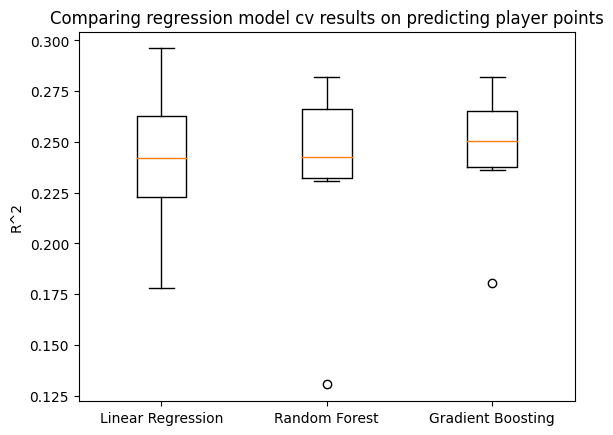

In [50]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Create X and y
features =['id_player','id_team','id_position','id_opponent','was_home','value','points_form','minutes_form','bps_form']
target = ['total_points']

X = player_points[features]
y = player_points[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Regressors:

linear_model =  LinearRegression()
random_forest_model = RandomForestRegressor(random_state=42)
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

models = {"Linear Regression": linear_model, "Random Forest": random_forest_model, "Gradient Boosting": gradient_boosting_model}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.title("Comparing regression model cv results on predicting player points")
plt.ylabel('R^2')

plt.show()

An R² score of 0.23 means the models provide a partial explanation of the variance in the data, but there is room for improvement, either by refining the features, choosing a more appropriate model, or incorporating additional relevant variables. 

### Feature Importance

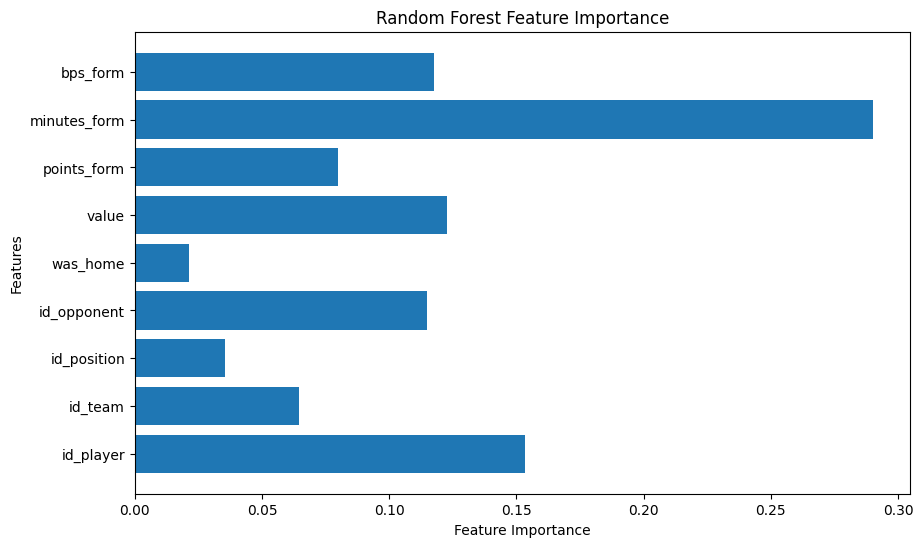

In [51]:
random_forest_model.fit(X_train_scaled, y_train)

# Extract feature importance
feature_importance = random_forest_model.feature_importances_
features = ['id_player', 'id_team', 'id_position', 'id_opponent', 'was_home', 'value', 'points_form', 'minutes_form', 'bps_form']

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


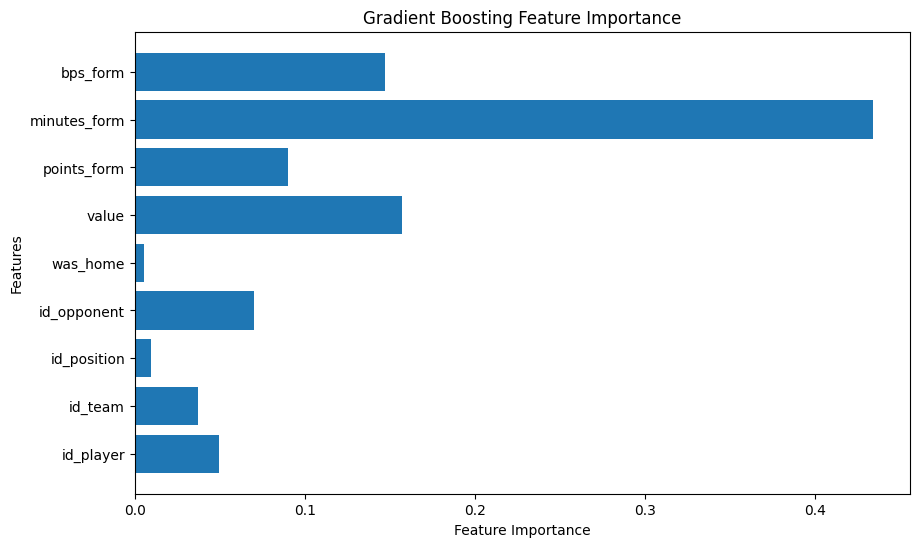

In [52]:
gradient_boosting_model.fit(X_train_scaled, y_train)

# Extract feature importance
feature_importance = gradient_boosting_model.feature_importances_
features = ['id_player', 'id_team', 'id_position', 'id_opponent', 'was_home', 'value', 'points_form', 'minutes_form', 'bps_form']

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importance')
plt.show()


### XGBoost with Hyper-parameter Tuning

The final method emplored with be an XGBoost. The XGBoost model will undergo individual training and evaluation. To enhance its performance, we will employ hyperparameter tuning to optimize the model's settings and potentially improve the outcomes. This step will be conducted separately to focus on maximizing the accuracy and efficiency of the XGBoost model.

In [53]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, r2_score

df = player_points
features =['id_player','id_team','id_position','id_opponent','value','points_form','minutes_form','bps_form']
target = ['total_points']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(n_estimators=20,objective='reg:squarederror', seed=42)

# Fit the regressor to the training set
xg_reg.fit(X_train_scaled,y_train)

# Predict the labels of the test set: preds
y_pred = xg_reg.predict(X_test_scaled)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Compute the rmse: rmse
rmse = np.sqrt(mse)
print("RMSE: %f" % (rmse))


Mean Squared Error: 4.424833470529284
R-squared: 0.2719621212085507
RMSE: 2.103529


An added advantage of training an XGBoost model, is you can access the individual decision trees that were created during the training process. These trees can be visualized graphically, showing how the model is making decisions at each node based on the feature values. By visualizing these trees, data scientists and analysts can gain insights into which features are most influential, how they interact, and the decision-making process of the model.

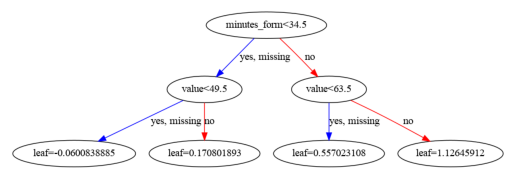

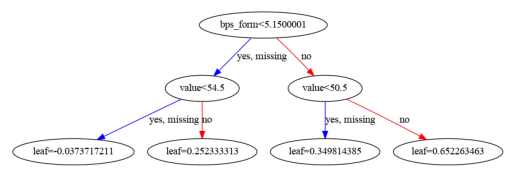

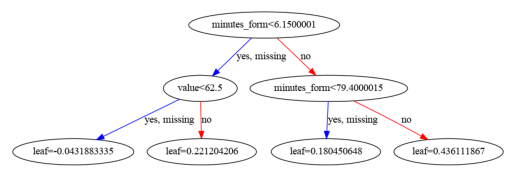

In [59]:
import matplotlib.pyplot as plt

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=5)

for i in range(3):

    # Plot the first tree
    xgb.plot_tree(xg_reg, num_trees=i)
    plt.show()


What is the optimal value for max depth? Use GridSearch to explore solution space

In [56]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import KFold

# Assuming you have defined your X_train and y_train datasets
kf = KFold(n_splits=6, random_state=42, shuffle=True)

# Set up the parameter grid
param_grid = {
    'max_depth': [2, 3, 5],  # Example values for max_depth
    'learning_rate': [0.01, 0.1, 0.3],  # Example values for learning_rate
    'n_estimators': [50, 100, 200],  # Example values for n_estimators
    # Add more parameters to be tuned as needed
}

# Instantiate xg_reg
xg_reg = xgb.XGBRegressor()

# Instantiate GridSearchCV
xg_cv = GridSearchCV(xg_reg, param_grid, cv=kf, scoring='r2', n_jobs=-1)

# Fit to the training data
xg_cv.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print("Tuned XGBoost parameters: {}".format(xg_cv.best_params_))
print("Tuned XGBoost R^2 score: {}".format(xg_cv.best_score_))

Tuned XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Tuned XGBoost R^2 score: 0.25459180691250766


[12:45:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




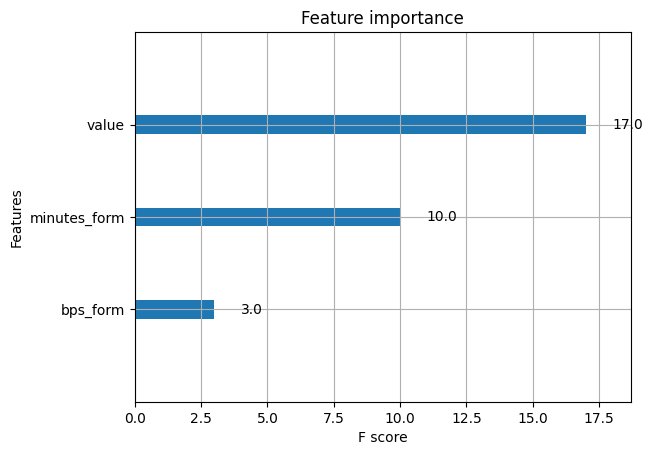

In [57]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = xg_cv.best_params_

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

## 8. Conclusion 

In conclusion, the exploratory data analysis (EDA) conducted throughout this project and the comprehensive examination of the Fantasy Premier League (FPL) dataset provided valuable insights into player performance dynamics.

Additionally, the application of simple machine learning algorithms during the analysis phase yielded results that were not only insightful but also comparable, showcasing the effectiveness of these techniques in extracting meaningful patterns from the data. 

This project has been a valuable learning experience, offering a hands-on opportunity to apply data science concepts to real-world scenarios. The combination of data visualizations and machine learning has proven to be a powerful approach in uncovering patterns within the FPL dataset.